### Domain Generalization (DG) Strategy

**Goal:** Assess the ability of a random forest to predict price classes on cities that were not seen during training.

#### 1. Building the Multi-Domain Dataset
* **Source Cities (Train):** Paris + Rome + Madrid 
* **Target City (Test):** Vienna
* **Rationale:** Including a variety of domains reduces city-specific bias and encourages the model to learn more universal features.

#### 2. Distribution Alignment
Continuous features (distance, scores) are standardized relative to the mean and standard deviation of their own city.
The Q1–Q4 classes are defined on each city's price distribution independently.

#### 3. Evaluation
* Comparison of accuracy between within-city testing (Test on Paris) and cross-city testing (Test on Vienna).
* Feature importance analysis: do the important variables stay the same across countries?

No need to re-run this — the dataframe is already built and ready to use.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV

In [2]:
processed_files = {
    "paris": "data/paris_dataset_final_ready.csv.gz",
    "rome": "data/rome_dataset_final_ready.csv.gz",
    "madrid": "data/madrid_dataset_final_ready.csv.gz"
}

# 1. Load and concatenate all city datasets
li = []
for city, path in processed_files.items():
    df = pd.read_csv(path, compression='gzip')
    li.append(df)

df_train_global = pd.concat(li, axis=0, ignore_index=True)

print(f" Merged global dataset: {df_train_global.shape}")
print(f" Breakdown by city:\n{df_train_global['city_label'].value_counts()}")

 Merged global dataset: (125628, 30)
 Breakdown by city:
city_label
Paris     73111
Rome      33564
Madrid    18953
Name: count, dtype: int64


Random forest model trained on Paris, Rome and Madrid data, then tested on Vienna.

We apply cross-stratification on city and price quantile to make sure classes are balanced across splits. This stratification is also used to reduce the dataset size before running the grid search.

In [3]:
stratify_key = df_train_global['city_label'].astype(str) + "_" + df_train_global['target_class'].astype(str)

print("Distribution of the 12 subgroups before sampling:")
print(stratify_key.value_counts(normalize=True).head())

Distribution of the 12 subgroups before sampling:
Paris_0    0.152148
Paris_2    0.145660
Paris_3    0.145262
Paris_1    0.138894
Rome_1     0.067907
Name: proportion, dtype: float64


In [4]:
df_search, _ = train_test_split(
    df_train_global, 
    train_size=0.25,     # keep 25% for the Grid Search (around 30k rows)
    stratify=stratify_key,   
    random_state=123
)

In [5]:
# Split into X (features) and y (target)
y_search = df_search['target_class']
X_search = df_search.drop(columns=['target_class', 'price_clean', 'city_label'])  
# also drop 'price_clean' since it's just metadata

print(f"\nFeatures (X) : {X_search.shape[1]} columns")
print(f"Target (y) : {len(y_search)} values")
print(f"\nClass distribution:")
print(y_search.value_counts().sort_index())

# For the final training run
X_train_full = df_train_global.drop(columns=['target_class', 'price_clean', 'city_label'])
y_train_full = df_train_global['target_class']

print(f"Shape of X_search (Grid Search) : {X_search.shape}")
print(f" Shape of X_train_full (Final) : {X_train_full.shape}")


Features (X) : 27 columns
Target (y) : 31407 values

Class distribution:
target_class
0    8077
1    7682
2    7820
3    7828
Name: count, dtype: int64
Shape of X_search (Grid Search) : (31407, 27)
 Shape of X_train_full (Final) : (125628, 27)


In [6]:
# Check that stratification worked as expected
print("Checking distribution of Paris_0:")
prop_full = (stratify_key == "Paris_0").mean()
prop_search = ((df_search['city_label'] == 'Paris') & (df_search['target_class'] == 0)).mean()
print(f"   In the full 125k rows : {prop_full*100:.2f}%")
print(f"   In the 25k subsample  : {prop_search*100:.2f}%")

Checking distribution of Paris_0:
   In the full 125k rows : 15.21%
   In the 25k subsample  : 15.21%


Grid search to find the best hyperparameters using cross-validation

In [7]:
param_grid = {
# Deeper trees since the data is more "complex"
    'max_depth': [15, 20, 25, None],
    # Forcing leaves to contain more samples helps the model group listings
    # from different cities together, pushing it to find cross-city patterns
    # rather than city-specific ones.
    'min_samples_leaf': [2, 5, 10],  
    # Minimum number of samples required to split a node
    'min_samples_split': [5, 10, 20],
    'n_estimators': [200, 300],
    # Keeping this fixed to limit computation time
    'max_features': ['sqrt']
}

In [8]:
print(y_search.value_counts(normalize=True))

target_class
0    0.257172
3    0.249244
2    0.248989
1    0.244595
Name: proportion, dtype: float64


In [9]:
def run_domain_generalization_grid_search(X, y, param_grid, cv_folds=3, scoring_metric='f1_macro'):
    print(f"Multi-domain Grid Search (metric: {scoring_metric}, CV: {cv_folds})")
    
    rf = RandomForestClassifier(random_state=42, n_jobs=-1)
    
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=cv_folds,             # 3-Fold Cross Validation
        scoring=scoring_metric,
        return_train_score=True, 
        n_jobs=-1,
        verbose=1
    )
    
    # Train on the stratified subsample
    grid_search.fit(X, y)
    
    results = pd.DataFrame(grid_search.cv_results_)
    
    cols_interest = [
        'param_max_depth', 
        'param_max_features', 
        'param_min_samples_leaf', 
        'param_min_samples_split', 
        'param_n_estimators',
        'mean_test_score',        
        'std_test_score',          # variance across folds
        'mean_train_score'         
    ]
    summary = results[cols_interest].copy()
    
    summary.rename(columns={
        'mean_test_score': 'Mean_CV_Score',
        'std_test_score': 'CV_Std (Variance)',
        'mean_train_score': 'Train_Score (Overfit?)'
    }, inplace=True)
    
    summary = summary.sort_values(by='Mean_CV_Score', ascending=False)
    
    return grid_search.best_estimator_, summary


In [10]:
best_model_dg, res_dg = run_domain_generalization_grid_search(
    X_search, 
    y_search, 
    param_grid=param_grid, 
    cv_folds=3, 
    scoring_metric='f1_macro'
)

print("Top 5 configurations (domain generalization - F1-macro):")
print(res_dg.head(5).to_string(index=False))


Multi-domain Grid Search (metric: f1_macro, CV: 3)
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Top 5 configurations (domain generalization - F1-macro):
param_max_depth param_max_features  param_min_samples_leaf  param_min_samples_split  param_n_estimators  Mean_CV_Score  CV_Std (Variance)  Train_Score (Overfit?)
             25               sqrt                       2                       10                 200       0.546220           0.001192                0.865382
             25               sqrt                       2                        5                 200       0.545987           0.003983                0.941918
             25               sqrt                       2                        5                 300       0.545893           0.003926                0.942493
           None               sqrt                       2                       10                 300       0.545705           0.003713                0.867508
             25     

In [11]:
# optimal parameters hardcoded for final training
best_params_dg = {
    'max_depth': 25,
    'max_features': 'sqrt',
    'min_samples_leaf': 2,
    'min_samples_split': 10,
    'n_estimators': 100
}


Training on (125628, 27)
OOB Score: 0.5755
               Feature  Importance
        dist_to_center    0.160489
      neigh_popularity    0.105857
     number_of_reviews    0.089571
minimum_nights_avg_ntm    0.082723
          accommodates    0.076025
              bedrooms    0.072284
         bathrooms_qty    0.050157
                  beds    0.045380
    score_chef_kitchen    0.039020
          score_coffee    0.027751


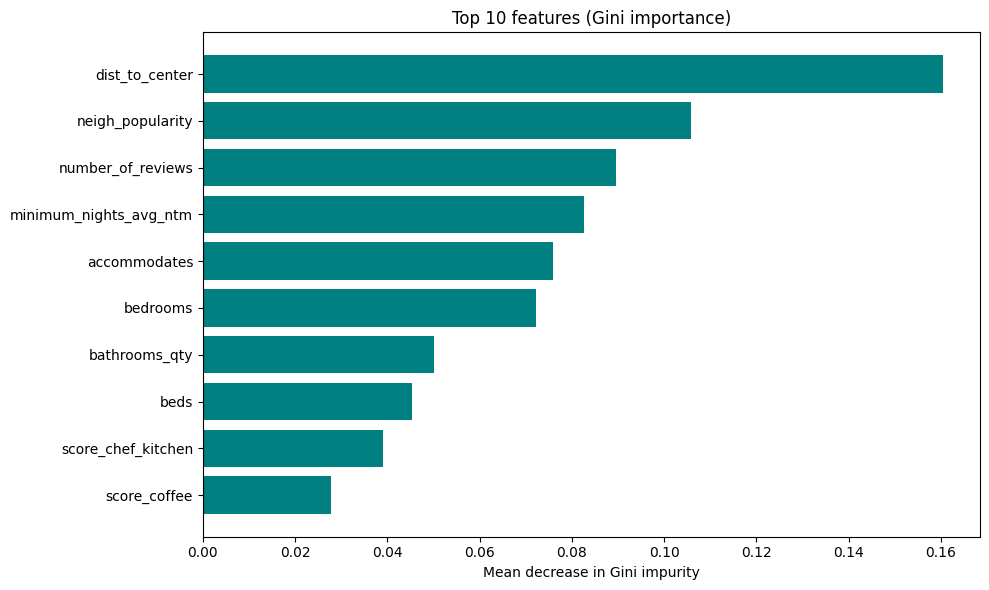

In [12]:
from sklearn.utils.class_weight import compute_sample_weight


# Using the parameters from Model #1 validated earlier
final_rf = RandomForestClassifier(
    max_depth=25,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=10,
    n_estimators=200,
    oob_score=True,       # estimates generalization without a separate validation set
    random_state=123,
    n_jobs=-1
)

# Domain weighting: prevents Paris (75k rows) from overwhelming Rome and Madrid (25k each)
# compute_sample_weight assigns weights inversely proportional to domain size
domain_weights = compute_sample_weight(
    class_weight='balanced', 
    y=df_train_global['city_label'] 
)
# Train on the full dataset
print(f"Training on {X_train_full.shape}")

final_rf.fit(X_train_full, y_train_full, sample_weight=domain_weights)

print(f"OOB Score: {final_rf.oob_score_:.4f}")

# Feature importances
feature_importances = pd.DataFrame({
    'Feature': X_train_full.columns,
    'Importance': final_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances.head(10).to_string(index=False))

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'][:10][::-1], feature_importances['Importance'][:10][::-1], color='teal')
plt.title("Top 10 features (Gini importance)")
plt.xlabel("Mean decrease in Gini impurity")
plt.tight_layout()
plt.show()


In [13]:
def rerank_predictions(y_proba):
    """
    Takes model probabilities (N, 4) and forces a balanced distribution
    across 4 quartiles (25% each) based on the expected class value.
    """
    # Compute expected class value (continuous score from 0 to 3)
    classes = np.array([0, 1, 2, 3])
    expected_scores = np.dot(y_proba, classes)
    
    # Rank all listings; 'first' breaks ties by order of appearance
    ranks = pd.Series(expected_scores).rank(method='first')
    
    # Cut into 4 strict quartiles
    y_pred_reranked = pd.qcut(ranks, q=4, labels=[0, 1, 2, 3]).astype(int)
    
    return y_pred_reranked.values


In [14]:
from sklearn.metrics import f1_score

df_vienna = pd.read_csv("data/vienna_dataset_final_ready.csv.gz", compression='gzip')
X_test_vienna, y_test_vienna = df_vienna.drop(columns=['target_class', 'price_clean', 'city_label']), df_vienna['target_class']

# Direct prediction
y_pred_vienna = final_rf.predict(X_test_vienna)

# Prediction with reranking
y_proba_vienna = final_rf.predict_proba(X_test_vienna)
y_pred_reranked_vienna = rerank_predictions(y_proba_vienna)

print("Without reranking (F1-Macro):", f1_score(y_test_vienna, y_pred_vienna, average='macro'))
print("With reranking (F1-Macro):", f1_score(y_test_vienna, y_pred_reranked_vienna, average='macro'))

print("\nClassification report (with reranking):")
print(classification_report(y_test_vienna, y_pred_reranked_vienna))


Without reranking (F1-Macro): 0.4257439818314406
With reranking (F1-Macro): 0.46871308752206275

Classification report (with reranking):
              precision    recall  f1-score   support

           0       0.58      0.56      0.57      2662
           1       0.34      0.34      0.34      2562
           2       0.35      0.36      0.35      2513
           3       0.61      0.61      0.61      2569

    accuracy                           0.47     10306
   macro avg       0.47      0.47      0.47     10306
weighted avg       0.47      0.47      0.47     10306



Leave-One-City-Out: train on 3 cities, test on the 4th — a clean way to evaluate domain generalization.

In [15]:
def run_ultimate_lodo_cv(df_all_cities, best_params):
    print("LODO cross-validation (raw vs reranking)...")
    print("-" * 75)
    
    cities = df_all_cities['city_label'].unique()
    results = []
    
    for test_city in cities:
        print(f"\nTraining on all other cities -> testing on {test_city.upper()}")
        
        # Train/test split by domain
        df_train = df_all_cities[df_all_cities['city_label'] != test_city]
        df_test  = df_all_cities[df_all_cities['city_label'] == test_city]
        
        # Drop price_clean to avoid any data leakage
        X_train = df_train.drop(columns=['target_class', 'price_clean', 'city_label'])
        y_train = df_train['target_class']
        
        X_test = df_test.drop(columns=['target_class', 'price_clean', 'city_label'])
        y_test = df_test['target_class']
        
        # Domain weighting
        print(f"   [Train] {len(df_train)} listings, balancing city weights...")
        domain_weights = compute_sample_weight(
            class_weight='balanced', 
            y=df_train['city_label']
        )

        rf = RandomForestClassifier(
            **best_params, 
            random_state=42, 
            n_jobs=-1,
            class_weight='balanced'
        )
        rf.fit(X_train, y_train, sample_weight=domain_weights)
        
        # Raw prediction and reranking
        print(f"   [Test]  {len(df_test)} listings from {test_city.capitalize()}...")
        
        y_pred_raw = rf.predict(X_test)
        
        y_proba = rf.predict_proba(X_test)
        y_pred_reranked = rerank_predictions(y_proba)

        f1_mac_raw = f1_score(y_test, y_pred_raw, average='macro')
        acc_raw = accuracy_score(y_test, y_pred_raw)
        
        f1_mac_reranked = f1_score(y_test, y_pred_reranked, average='macro')
        acc_reranked = accuracy_score(y_test, y_pred_reranked)
        
        delta_f1 = (f1_mac_reranked - f1_mac_raw) * 100
        
        print(f"   {test_city.capitalize()} (raw)      -> F1-macro: {f1_mac_raw:.4f} | Accuracy: {acc_raw:.4f}")
        print(f"   {test_city.capitalize()} (reranked) -> F1-macro: {f1_mac_reranked:.4f} | Accuracy: {acc_reranked:.4f}")
        print(f"   Reranking gain: +{delta_f1:.2f} pts of F1-Macro")
        
        results.append({
            'Target_City (Test)': test_city.capitalize(),
            'Source_Cities (Train)': ", ".join([c.capitalize() for c in cities if c != test_city]),
            'F1_Macro_Raw': f1_mac_raw,
            'F1_Macro_Reranked': f1_mac_reranked,
            'Accuracy_Raw': acc_raw,
            'Accuracy_Reranked': acc_reranked
        })

    
    df_results = pd.DataFrame(results)
    
    mean_f1_raw = df_results['F1_Macro_Raw'].mean()
    mean_f1_reranked = df_results['F1_Macro_Reranked'].mean()
    mean_acc_raw = df_results['Accuracy_Raw'].mean()
    mean_acc_reranked = df_results['Accuracy_Reranked'].mean()
    
    df_results.loc['Global Average'] = [
        "-", "-", 
        mean_f1_raw, mean_f1_reranked, 
        mean_acc_raw, mean_acc_reranked
    ]
    
    return df_results


In [16]:
df_paris = pd.read_csv("data/paris_dataset_final_ready.csv.gz", compression='gzip')
df_rome = pd.read_csv("data/rome_dataset_final_ready.csv.gz", compression='gzip')
df_madrid = pd.read_csv("data/madrid_dataset_final_ready.csv.gz", compression='gzip')

df_all_cities = pd.concat([df_paris, df_rome, df_madrid, df_vienna], ignore_index=True)

tableau_final_lodo = run_ultimate_lodo_cv(df_all_cities, best_params_dg)
display(tableau_final_lodo)

LODO cross-validation (raw vs reranking)...
---------------------------------------------------------------------------

Training on all other cities -> testing on PARIS
   [Train] 62823 listings, balancing city weights...
   [Test]  73111 listings from Paris...
   Paris (raw)      -> F1-macro: 0.4436 | Accuracy: 0.4539
   Paris (reranked) -> F1-macro: 0.4555 | Accuracy: 0.4568
   Reranking gain: +1.19 pts of F1-Macro

Training on all other cities -> testing on ROME
   [Train] 102370 listings, balancing city weights...
   [Test]  33564 listings from Rome...
   Rome (raw)      -> F1-macro: 0.4026 | Accuracy: 0.4144
   Rome (reranked) -> F1-macro: 0.4357 | Accuracy: 0.4357
   Reranking gain: +3.30 pts of F1-Macro

Training on all other cities -> testing on MADRID
   [Train] 116981 listings, balancing city weights...
   [Test]  18953 listings from Madrid...
   Madrid (raw)      -> F1-macro: 0.4593 | Accuracy: 0.4997
   Madrid (reranked) -> F1-macro: 0.5173 | Accuracy: 0.5173
   Reranking 

,Target_City (Test),Source_Cities (Train),F1_Macro_Raw,F1_Macro_Reranked,Accuracy_Raw,Accuracy_Reranked
0,Paris,"Rome, Madrid, Vienna",0.443641,0.455503,0.453926,0.456812
1,Rome,"Paris, Madrid, Vienna",0.402610,0.435658,0.414402,0.435735
2,Madrid,"Paris, Rome, Vienna",0.459329,0.517323,0.499710,0.517280
3,Vienna,"Paris, Rome, Madrid",0.431529,0.469484,0.435377,0.470309
Global Average,-,-,0.434277,0.469492,0.450854,0.470034


This project shows that the naive approach — training a model on one city and applying it directly to another — breaks down in practice due to geographic and economic differences. To build a model that actually generalises across Europe, we had to address two main challenges: differences in feature distributions between cities, and a shift in price distributions.

Our final pipeline handles both through two key techniques:

### 1. Domain Invariance
During training, weighting samples inversely to city size prevents the model from simply memorising the patterns of the dominant city (Paris). This forces it to learn rules that hold across all cities.

### Calibration/reranking
By construction, the ground truth of our target variable follows a strict uniform distribution: each price quartile represents exactly **25%** of listings in a given city. 
However, due to residual domain shift, the raw `.predict()` output tends to produce a biased marginal distribution. It relies on the naive **Maximum A Posteriori** rule, which ignores the ordinal nature of price levels.

Our reranker corrects this using Bayesian decision theory:
* Instead of a hard class assignment, we compute the **posterior expected value** $E[Y|X] = \sum (y \times P(Y=y|X))$. This estimator minimises risk on ordinal targets like prices.
* We then rank these continuous scores and bin them into equal quartiles. This **post-hoc regularisation** aligns predictions with our known *a priori* distribution (25% per class).

To verify that the observed performance gain (often above +4 F1-Macro points) is not just noise, we close this study with a **McNemar statistical test**.


In [ ]:
from statsmodels.stats.contingency_tables import mcnemar
# We used a coding agent to help implementing the test with statsmodels
print("Null Hypothesis (H0): The raw model and the reranked model have the same error rate.")
print("Alternative Hypothesis (H1): Reranking significantly changes model performance.\n")

# Boolean vectors, testing on the first model (Vienna)
correct_raw = (y_pred_vienna == y_test_vienna)
correct_reranked = (y_pred_reranked_vienna == y_test_vienna)

# Build the McNemar contingency table
# We only care about cases where the two models disagree
table = [
    [sum(~correct_raw & ~correct_reranked), sum(~correct_raw & correct_reranked)],
    [sum(correct_raw & ~correct_reranked),  sum(correct_raw & correct_reranked)]
]

print("Contingency table (disagreements):")
print(f"Raw was wrong, reranking fixed it: {table[0][1]} listings")
print(f"Raw was right, reranking broke it: {table[1][0]} listings\n")

result = mcnemar(table)

print(f"Test p-value: {result.pvalue:.5e}")

if result.pvalue < 0.05:
    print("result: H0 rejected.")
    print("The gain from reranking is statistically significant.")
    print("Calibration validated successfully.")
else:
    print("RESULT: Failed to reject H0.")
    print("The difference may be due to random variation on this sample.")


Null Hypothesis (H0): The raw model and the reranked model have the same error rate.
Alternative Hypothesis (H1): Reranking significantly changes model performance.

Contingency table (disagreements):
Raw was wrong, reranking fixed it: 1475 listings
Raw was right, reranking broke it: 1063 listings

Test p-value: 2.93520e-16
result: H0 rejected.
The gain from reranking is statistically significant.
Calibration validated successfully.
